# Home Credit Default Risk - Kaggle competition

# Initial Setup

#### Import packages

In [70]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import os
 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm # used for regression spline
from patsy import dmatrix

import warnings
warnings.filterwarnings('ignore')

# To display plots properly
%matplotlib inline

#### Load datasets

In [71]:
file_path = "C:\\Users\\DS Miranda\\Documents\\Work\\kaggle-home-credit\\data\\"

# List files available
print(os.listdir(file_path))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [72]:
# Training data
# Contains loan and applicant information, including the TARGET variable 
# (whether the loan was repaid on time or not).
# One row represents one loan in the sample. 
app_train = pd.read_csv(os.path.join(file_path,'application_train.csv'))
print('Training data shape: ', app_train.shape)
# app_train.head()

# Test data
# As for trianing data, without the TARGET variable.
app_test = pd.read_csv(os.path.join(file_path, 'application_test.csv'))
print('Test data shape: ', app_test.shape)
# app_test.head()

# Bureau data
# All of the client's previous credits provided by other financial institutions
# that were reported to the Credit Bureau. One row represents one Credit Bureau loan.
bureau = pd.read_csv(os.path.join(file_path, 'bureau.csv'))
print('Bureau data shape: ', bureau.shape)
# bureau.head()

# Previous applications data
# All previous applications for Home Credit loans of clients who have loans in the sample.
# One row represents one previous application for a Home Credit loan.
prev_app = pd.read_csv(os.path.join(file_path,'previous_application.csv'))
print('Previous application data shape: ', prev_app.shape)
# prev_app.head()

# Variable descritpions
col_desc = pd.read_csv(os.path.join(file_path, 'HomeCredit_columns_description.csv'), 
                       usecols=range(1,5), encoding = "ISO-8859-1")

Training data shape:  (307511, 122)
Test data shape:  (48744, 121)
Bureau data shape:  (1716428, 17)
Previous application data shape:  (1670214, 37)


In [73]:
# Check whether SK_ID_CURR is unique in bureau and previous app datasets

print('Of {} current loans, {} are unique.'.format(
    len(app_train['SK_ID_CURR']), len(app_train['SK_ID_CURR'].unique())))

print('Of {} previous Credit Bureau loans, {} are unique.'.format( 
    len(bureau['SK_ID_CURR']), len(bureau['SK_ID_CURR'].unique())))

print('Of {} previous Home Credit loans, {} are unique.'.format( 
    len(prev_app['SK_ID_CURR']), len(prev_app['SK_ID_CURR'].unique())))

Of 307511 current loans, 307511 are unique.
Of 1716428 previous Credit Bureau loans, 305811 are unique.
Of 1670214 previous Home Credit loans, 338857 are unique.


There can be multiple prior loans in bureau and previous applications dataset per current loan in the training dataset. This makes it challenging to merge previous loan data into the training dataset for exploratory analysis.

We will instead merge the target variable from the training dataset into the bureau and previous application datasets, respectively.

In [74]:
print('Bureau shape before merge: ', bureau.shape)
bureau_tgt = pd.merge(left=bureau, right=app_train[['SK_ID_CURR','TARGET']],
                 on='SK_ID_CURR', how='left')
print('Bureau shape after merge: ', bureau_tgt.shape, '\n')

print('Prev app shape before merge: ', prev_app.shape)
prev_app_tgt = pd.merge(left=prev_app, right=app_train[['SK_ID_CURR','TARGET']],
                 on='SK_ID_CURR', how='left')
print('Prev app shape after merge: ', prev_app_tgt.shape)

Bureau shape before merge:  (1716428, 17)
Bureau shape after merge:  (1716428, 18) 

Prev app shape before merge:  (1670214, 37)
Prev app shape after merge:  (1670214, 38)


## Exploratory Data Analysis

### Distribution of target column

In [238]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

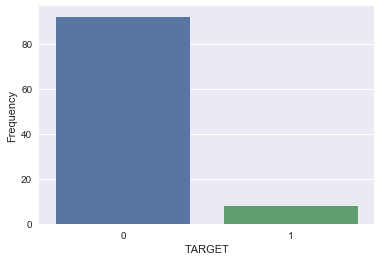

In [75]:
ax = sns.barplot(x="TARGET", y="TARGET", data=app_train, estimator=lambda x: len(x) / len(app_train) * 100, );
ax.set(ylabel='Frequency');
plt.show()

We appear to have an imbalanced class problem. Many more people were classified as repaying loans on time (0) than not (1).

### Missing values
Next we look at the number and percentage of missing values in each column. Missing values will need to be imputed before applying most machine learning models.

In [76]:
def missing_vals_table(df):
    # Function to calculate missing values by column
    
    # Total number of missing values
    mv = df.isnull().sum()
    
    # Percentage of values that are missing
    mv_pc = 100*df.isnull().sum()/len(df)
    
    # Create table with results
    mv_tbl = pd.concat([mv, mv_pc], axis=1)
    
    # Rename columns
    mv_tbl_rn = mv_tbl.rename(
    columns = {0:'Missing Values', 1: '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mv_tbl_rn =mv_tbl_rn[
        mv_tbl_rn.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print summary info
    print('Dataframe has ' + str(df.shape[1]) + ' columns.\n' +
         'There are ' + str(mv_tbl_rn.shape[0]) + 
         ' columns with missing values.')
    
    return mv_tbl_rn
    

In [77]:
# Missing values statistics - training dataset
missing_values = missing_vals_table(app_train)
missing_values.head(10)

Dataframe has 122 columns.
There are 67 columns with missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [242]:
# Missing values statistics - bureau dataset
missing_values_bureau = missing_vals_table(bureau_tgt)
missing_values_bureau.head(10)

Dataframe has 18 columns.
There are 8 columns with missing values.


,Missing Values,% of Total Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
TARGET,251103,14.6
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


In [243]:
# Missing values statistics - prev applications dataset
missing_values_prev = missing_vals_table(prev_app_tgt)
missing_values_prev.head(10)

Dataframe has 38 columns.
There are 17 columns with missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_LAST_DUE,673065,40.3
NFLAG_INSURED_ON_APPROVAL,673065,40.3
DAYS_TERMINATION,673065,40.3
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3


### Column types

In [78]:
# Combine train and test datasets temporarily to ensure encoding is consistent across both datasets.
app_train['test_set'] = 0
app_test['test_set'] = 1

app_train_test = app_train.append(app_test)

In [79]:
# Create a dictionary of dataframes for convenience
df_dict = {
    "Training and test" : app_train_test,
    "Bureau" : bureau_tgt,
    "Prev apps" : prev_app_tgt
}

In [80]:
# Number of each column type
for key, value in df_dict.items():
    print(key, ' dataset: \n', value.dtypes.value_counts(), '\n', sep='')

Training and test dataset: 
float64    66
int64      41
object     16
dtype: int64

Bureau dataset: 
float64    9
int64      6
object     3
dtype: int64

Prev apps dataset: 
float64    16
object     16
int64       6
dtype: int64



In [81]:
# Number of unique values in categorical variables
for key, value in df_dict.items():
    print(key, ' dataset: \n',
          value.select_dtypes(['object']).apply(pd.Series.nunique, axis=0),
         '\n', sep='')

Training and test dataset: 
CODE_GENDER                    3
EMERGENCYSTATE_MODE            2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
dtype: int64

Bureau dataset: 
CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

Prev apps dataset: 
NAME_CONTRACT_TYPE              4
WEEKDAY_APPR_PROCESS_START      7
FLAG_LAST_APPL_PER_CONTRACT     2
NAME_CASH_LOAN_PURPOSE         25
NAME_CONTRACT_STATUS            4
NAME_PAYMENT_TYPE               4
CODE_REJECT_REASON              9
NAME_TYPE_SUITE                 7
NAME_CLIENT_TYPE                4
NAME_GO

#### Encoding categorical variables
We need to reencode the categorical variables as numbers before a machine learning model can deal wih them. We can do this by creating a dummy variable for each unique category in a given categorical variable ("one-hot encoding"). For variables with two or fewer categories, we instead apply "label encoding" (replace each category with a numerical label).

In [82]:
# Label encoding

def label_encode(df, key):
    le_count = 0

    # Iterate through columns
    for col in df:
        if df[col].dtype == 'object':
            if len(df[col].unique()) <=2:
                df[col] = df[col].astype('category')
                df[col] = df[col].cat.codes
                le_count += 1

    print('{} columns were label encoded in {} dataset.'.format(le_count, key))
    
    return df

for key, val in df_dict.items():
    val = label_encode(val, key)

3 columns were label encoded in Training and test dataset.
0 columns were label encoded in Bureau dataset.
1 columns were label encoded in Prev apps dataset.


In [114]:
# One-hot encoding

def onehot_encode(df, key):
    df = pd.get_dummies(df)
    print('{} data shape: {}'.format(key, df.shape))
    
    return df

app_train = onehot_encode(app_train, 'Training and test')
bureau_tgt = onehot_encode(bureau_tgt, 'Bureau')
prev_app_tgt = onehot_encode(prev_app_tgt, 'Prev applications')

# For loop not modifying actual dataframes for some reason
# for key, val in df_dict.items():
#     df_dict[key] = onehot_encode(val, key)
# print(bureau_tgt.shape)

Training and test data shape: (307511, 244)
Bureau data shape: (1716428, 38)
Prev applications data shape: (1670214, 164)


In [115]:
# Split combined training and test sets back into individual datasets

app_train = app_train_test.loc[(app_train_test['test_set']==0),].drop(['test_set'], axis=1)

app_test = app_train_test.loc[(app_train_test['test_set']==1),].drop(['test_set','TARGET'], axis=1)

### Oultiers
Next we will check for anomalies in the data. Anomalies may be the result of data entry errors, or they could be valid but extreme measurements. Anomalies can be detected visually using boxplots.

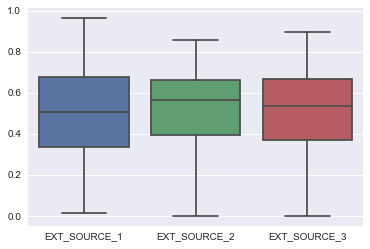

In [85]:
# Boxplots for external credit score variables
sns.boxplot(x=app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]);

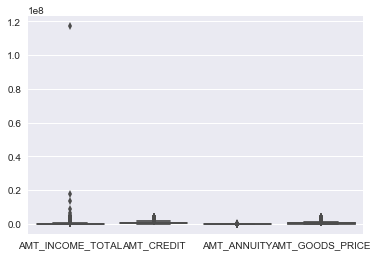

In [86]:
# Boxplots for dollar value variables
sns.boxplot(app_train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']]);

We would generally expect income to be a right-skewed variable, however the boxplot indicates that there are some suspicious outliers near the 120mn mark. Let's investigate further using describe() and a histogram.

In [87]:
app_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

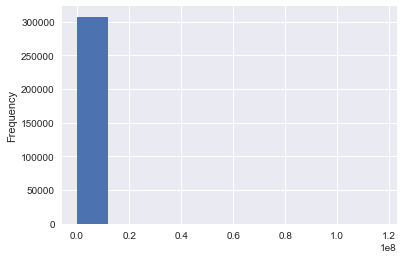

In [88]:
app_train['AMT_INCOME_TOTAL'].plot.hist();

In [89]:
# How many of these cases are there?
inc_anom = app_train[app_train['AMT_INCOME_TOTAL']>1.150000e+08]
print('There are {} anomolous income observations'.format(len(inc_anom)))

There are 1 anomolous income observations


Since there's only one observation this large, it's likely that's it's an erroneous input. We will set the value to missing.

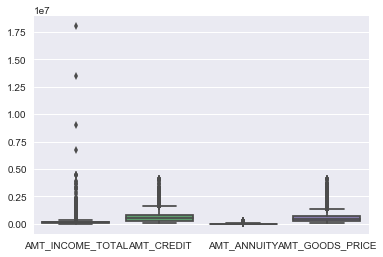

In [90]:
app_train['AMT_INCOME_TOTAL'].replace({1.170000e+08: np.nan}, inplace=True)

# Reproduce the boxplots
sns.boxplot(app_train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']]);

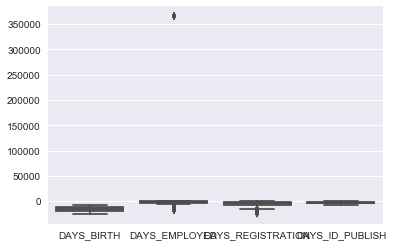

In [91]:
# Check variables measured in days
sns.boxplot(x=app_train[['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']]);

It appears as though we have some outliers in DAYS_EMPLOYED. Check by plotting a histogram and looking at the summary statistics.

In [92]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

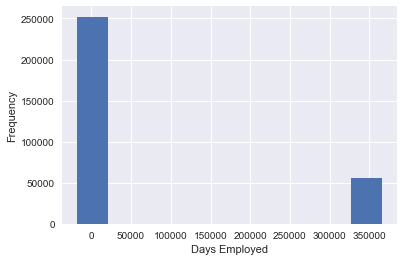

In [93]:
app_train['DAYS_EMPLOYED'].plot.hist();
plt.xlabel('Days Employed');

In [94]:
# How many of these cases are there?
emp_anom = app_train[app_train['DAYS_EMPLOYED']>300000]
print('There are {} anomolous days employed'.format(len(emp_anom)))
print('This represents {}% of the training set.'.format((100*len(emp_anom)/len(app_train))))

There are 55374 anomolous days employed
This represents 18.00716071945394% of the training set.


This represents a substantial share of the training set. We will do a bit more investigation before setting the values to missing. Let's check if these records tend to have a higher or lower rate of default than the remaining 82% of the set.

In [95]:
non_anom = app_train[app_train['DAYS_EMPLOYED']<300000]
print('Non-anomalies default on {}% of loans.'.format((100*non_anom['TARGET'].mean())))
print('Anomalies default on {}% of loans.'.format((100*emp_anom['TARGET'].mean())))

Non-anomalies default on 8.65997453765215% of loans.
Anomalies default on 5.399646043269405% of loans.


There isn't a large difference between the default rate of anomalies and non-anomalies. We will set the outlier values to missing and create a variable to flag the outliers.

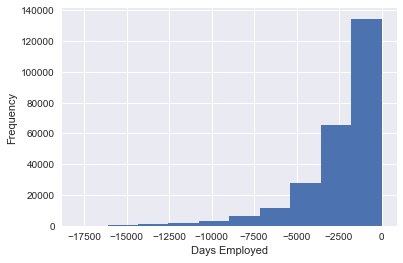

In [96]:
# Create outlier flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED']>300000

# Replace outliers with np.nan
app_train.loc[(app_train['DAYS_EMPLOYED_ANOM']==True),'DAYS_EMPLOYED']=np.nan

app_train['DAYS_EMPLOYED'].plot.hist();
plt.xlabel('Days Employed');

### Correlations
Computing Pearson correlations between features and the target is one way to get an idea about which features may be more interesting or important in determining default probability.

#### Training dataset

In [97]:
# Compute correlations between features and target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display strongest correlations
print('Most positive correlations:\n', correlations.tail(10), sep='')
print('\nMost negative correlations:\n', correlations.head(10), sep='')

Most positive correlations:
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most negative correlations:
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


The largest positive correlation comes from DAYS_BIRTH, suggesting that there may be some effect of age on default probability. The correlation is positive, but DAYS_BIRTH is measured in days before application date (i.e. the value fo the feature is negative), meaning that an increase in age is associated with a reduction in default probability.

Let's have a closer look at the relationship between age and default probability.

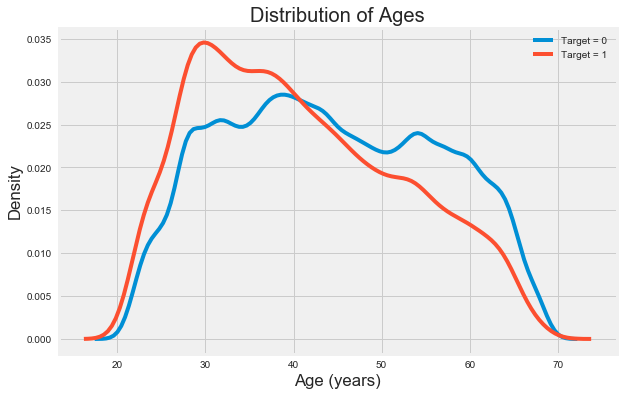

In [98]:
# Produce a KDE plot of age, coloured by default status.

plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

# DAYS_BIRTH is measured in days, so divide by 365 to get years.
# Multiply by -1 so that age is measured positively.
sns.kdeplot(-1*app_train.loc[app_train['TARGET']==0, 'DAYS_BIRTH']/365, label = 'Target = 0');
sns.kdeplot(-1*app_train.loc[app_train['TARGET']==1, 'DAYS_BIRTH']/365, label = 'Target = 1');
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The age distribution of defaulters (red line) is skewed slightly more towards younger ages than the non-defaulters (blue line). Although the correlation coefficient isn't very large, this feature may be important for modelling.

Another way to visualise the relationship is to plot default probability by age group. To do this, first split the data into five-year age group bins. Then compute default probability for each bin and plot in a histogram.

In [99]:
age_data = app_train[['DAYS_BIRTH','TARGET']]
age_data['YEARS_BIRTH'] = -1*age_data['DAYS_BIRTH']/365

# Create binned age variable
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20,70,11))
age_data.head()

,DAYS_BIRTH,TARGET,YEARS_BIRTH,YEARS_BINNED
0,-9461,1.0,25.920548,"(25.0, 30.0]"
1,-16765,0.0,45.931507,"(45.0, 50.0]"
2,-19046,0.0,52.180822,"(50.0, 55.0]"
3,-19005,0.0,52.068493,"(50.0, 55.0]"
4,-19932,0.0,54.608219,"(50.0, 55.0]"


In [100]:
age_grouped = age_data[['YEARS_BINNED','TARGET']].groupby('YEARS_BINNED').mean()
age_grouped

,TARGET
YEARS_BINNED,
"(20.0, 25.0]",0.123036
"(25.0, 30.0]",0.111436
"(30.0, 35.0]",0.102814
"(35.0, 40.0]",0.089414
"(40.0, 45.0]",0.078491
"(45.0, 50.0]",0.074171
"(50.0, 55.0]",0.066968
"(55.0, 60.0]",0.055314
"(60.0, 65.0]",0.052737


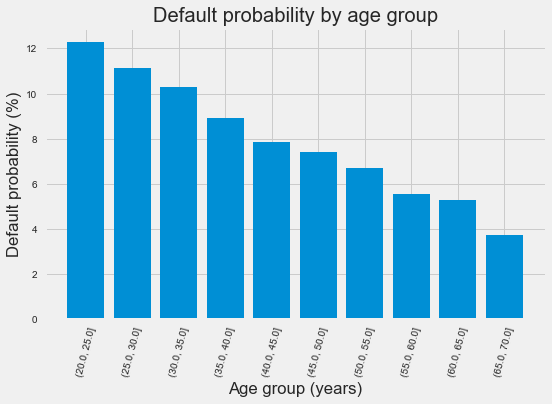

In [101]:
plt.figure(figsize=(8,5));

plt.bar(range(0, len(age_grouped)), 100*age_grouped['TARGET']);
plt.xticks(range(0, len(age_grouped)), [row for row in age_grouped.index.astype(str)],rotation=75);
plt.xlabel('Age group (years)'); plt.ylabel('Default probability (%)'); plt.title('Default probability by age group');

This chart shows a clearer trend: younger people are more likely to default on their loan.

Now let's repeat the above analyses for DAYS_EMPLOYED.

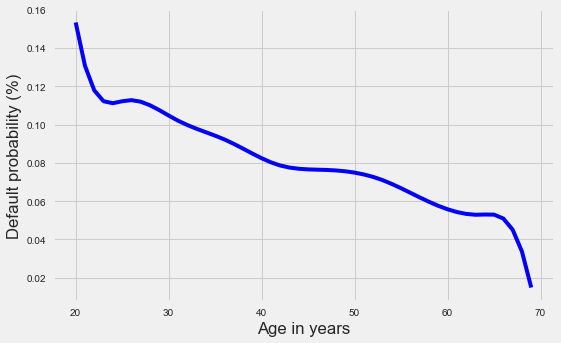

In [102]:
# An alternative way to display the default probability by age is by using a regression spline.

age_data = app_train[['DAYS_BIRTH','TARGET']]
age_data['YEARS_BIRTH'] = -1*age_data['DAYS_BIRTH']/365
age_grouped = dmatrix("bs(age_data.YEARS_BIRTH, df=11, include_intercept=False)",
                      {"age_data.YEARS_BIRTH": age_data.YEARS_BIRTH}, return_type='dataframe')

# Build a regular linear model from the splines
fit1 = sm.GLM(age_data.TARGET, age_grouped).fit()
age_grid = np.arange(20, 70).reshape(-1,1)
pred1 = fit1.predict(dmatrix("bs(age_grid, df=11, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))

plt.figure(figsize=(8,5));
plt.plot(age_grid, pred1, color='b')
plt.xlabel('Age in years')
plt.ylabel('Default probability (%)')
plt.show()

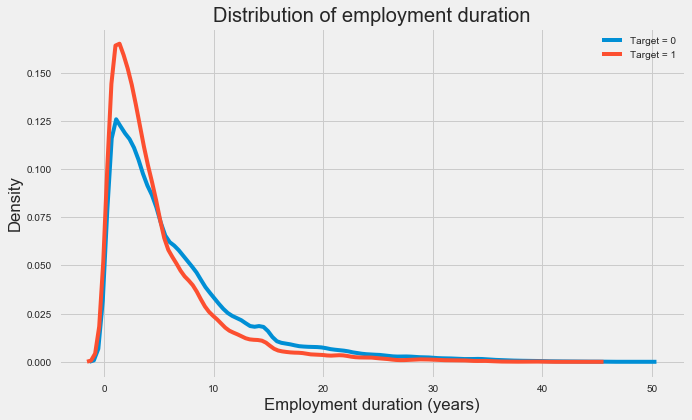

In [103]:
# KDE plot of days employed, coloured by default status.

plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

sns.kdeplot(-1*app_train.loc[app_train['TARGET']==0, 'DAYS_EMPLOYED']/365, label = 'Target = 0');
sns.kdeplot(-1*app_train.loc[app_train['TARGET']==1, 'DAYS_EMPLOYED']/365, label = 'Target = 1');
plt.xlabel('Employment duration (years)'); plt.ylabel('Density'); plt.title('Distribution of employment duration');

There's not a big difference in the distribution of length of employment between the two default statuses. Let's see if hte binned histogram provides any mroe information.

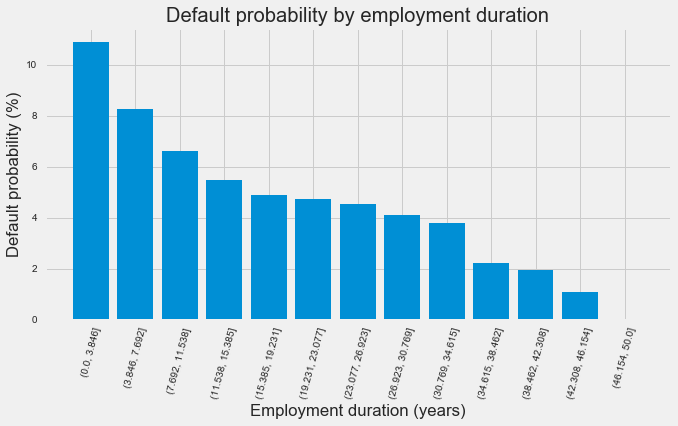

In [104]:
emp_data = app_train[['DAYS_EMPLOYED','TARGET']]
emp_data['YEARS_EMPLOYED'] = -1*emp_data['DAYS_EMPLOYED']/365

# Create binned age variable
emp_data['YEARS_BINNED'] = pd.cut(emp_data['YEARS_EMPLOYED'], bins = np.linspace(0,50,14))
emp_grouped = emp_data[['YEARS_BINNED','TARGET']].groupby('YEARS_BINNED').mean()

plt.figure(figsize=(10,5));

plt.bar(range(0, len(emp_grouped)), 100*emp_grouped['TARGET']);
plt.xticks(range(0, len(emp_grouped)), [row for row in emp_grouped.index.astype(str)],rotation=75);
plt.xlabel('Employment duration (years)'); plt.ylabel('Default probability (%)'); plt.title('Default probability by employment duration');

Now we will look at the three variables with the strongest negative correlation with the target: the three external credit score variables. The negative correlation indicates that the higher the external credit score, the less likely a person is to default on their loan.

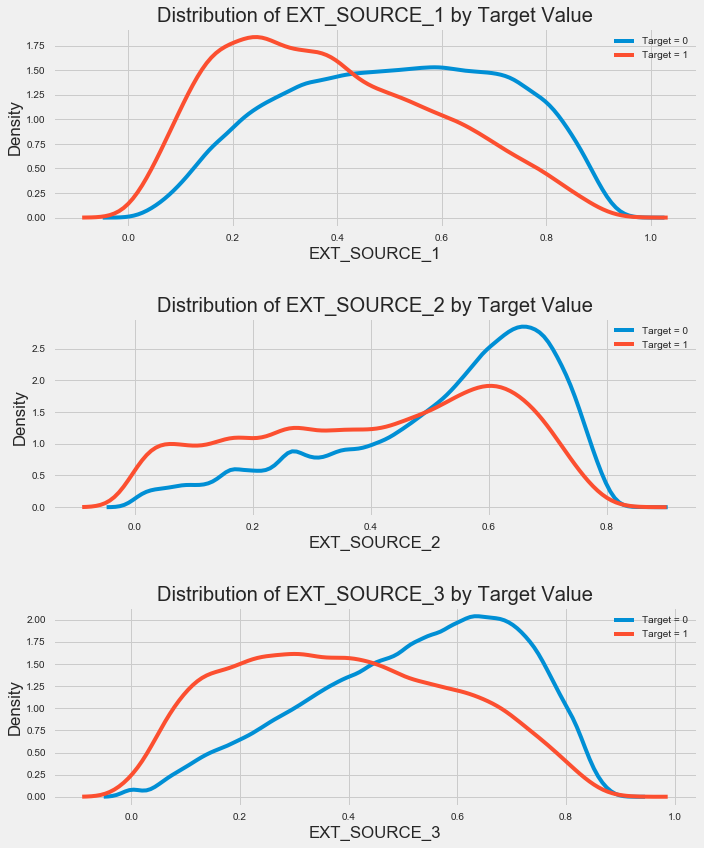

In [105]:
# Produce KDE plots for each of the external credit score variables, coloured by default status.

plt.figure(figsize = (10, 12))

# Iterate over each feature
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # Create a new subplot for each variable
    plt.subplot(3, 1, i+1)
    sns.kdeplot(app_train.loc[app_train['TARGET']==0, source], label = 'Target = 0')
    sns.kdeplot(app_train.loc[app_train['TARGET']==1, source], label = 'Target = 1')
    
    plt.title('Distribution of {} by Target Value'.format(source))
    plt.xlabel(source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

The largest difference in profiles can be seen for the third external source feature. 

#### Bureau dataset

In [106]:
# Compute correlations between features and target and sort
correlations_bureau = bureau_tgt.corr()['TARGET'].sort_values()

# Display strongest correlations
print('Most positive correlations:\n', correlations_bureau.tail(10), sep='')
print('\nMost negative correlations:\n', correlations_bureau.head(10), sep='')

Most positive correlations:
CREDIT_ACTIVE_Sold         0.005299
AMT_CREDIT_SUM_OVERDUE     0.006253
CREDIT_TYPE_Credit card    0.020331
DAYS_CREDIT_ENDDATE        0.026497
CREDIT_TYPE_Microloan      0.037583
DAYS_ENDDATE_FACT          0.039057
DAYS_CREDIT_UPDATE         0.041076
CREDIT_ACTIVE_Active       0.042045
DAYS_CREDIT                0.061556
TARGET                     1.000000
Name: TARGET, dtype: float64

Most negative correlations:
CREDIT_ACTIVE_Closed                        -0.042647
CREDIT_TYPE_Consumer credit                 -0.020315
CREDIT_TYPE_Mortgage                        -0.010892
CREDIT_TYPE_Car loan                        -0.010724
AMT_CREDIT_SUM                              -0.010606
SK_ID_BUREAU                                -0.009018
AMT_CREDIT_SUM_LIMIT                        -0.005990
CREDIT_CURRENCY_currency 2                  -0.003271
SK_ID_CURR                                  -0.003024
CREDIT_TYPE_Loan for business development   -0.002116
Name: TARGET, 

The correlations of the Bureau dataset features with the target variable are substantially smaller than for the Training dataset features. We will have a closer look at the relationship between DAYS_CREDIT and default probability. 

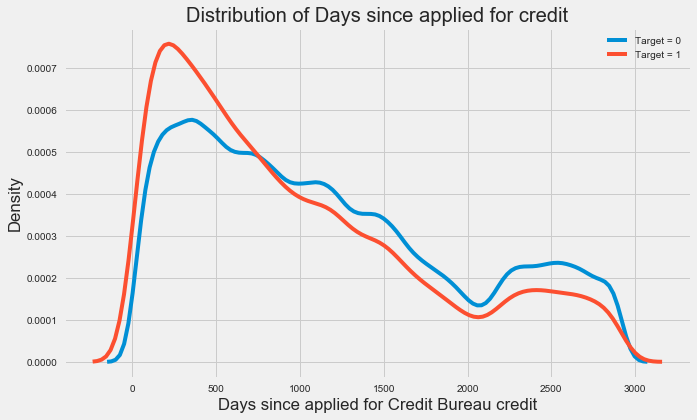

In [107]:
# Produce a KDE plot of DAYS_CREDIT, coloured by default status.

plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')

# DAYS_CREDIT is measured as the days before current application that the client pplied for Credit Bureau credit.
# Multiply by -1 so that feature is measured positively.
sns.kdeplot(-1*bureau_tgt.loc[bureau_tgt['TARGET']==0, 'DAYS_CREDIT'], label = 'Target = 0');
sns.kdeplot(-1*bureau_tgt.loc[bureau_tgt['TARGET']==1, 'DAYS_CREDIT'], label = 'Target = 1');
plt.xlabel('Days since applied for Credit Bureau credit'); plt.ylabel('Density'); plt.title('Distribution of Days since applied for credit');

Consistent with the relatively low correlation, there does not appear to be a large difference in the distribution of days since applied for Credit Bureau credit between those who defaulted on their current loan and those who did not.

#### Previous applications dataset

In [116]:
# Compute correlations between features and target and sort
correlations_prevapp = prev_app_tgt.corr()['TARGET'].sort_values()

# Display strongest correlations
print('Most positive correlations:\n', correlations_prevapp.tail(10), sep='')
print('\nMost negative correlations:\n', correlations_prevapp.head(10), sep='')

Most positive correlations:
RATE_INTEREST_PRIVILEGED                  0.028640
NAME_GOODS_CATEGORY_XNA                   0.029541
CNT_PAYMENT                               0.030480
CODE_REJECT_REASON_HC                     0.037158
CODE_REJECT_REASON_SCOFR                  0.038432
DAYS_DECISION                             0.039901
NAME_PRODUCT_TYPE_walk-in                 0.042842
NAME_CONTRACT_STATUS_Refused              0.054458
TARGET                                    1.000000
NAME_GOODS_CATEGORY_House Construction         NaN
Name: TARGET, dtype: float64

Most negative correlations:
CODE_REJECT_REASON_XAP                      -0.052015
NAME_CONTRACT_STATUS_Approved               -0.049161
DAYS_FIRST_DRAWING                          -0.031154
NAME_PORTFOLIO_POS                          -0.030791
NAME_CONTRACT_TYPE_Consumer loans           -0.029940
HOUR_APPR_PROCESS_START                     -0.027809
NAME_YIELD_GROUP_low_normal                 -0.026615
RATE_DOWN_PAYMENT         

Again, the correlations of the previous application dataset features with TARGET variable are not particularly strong.

We will look more closely at the varaibles NAME_CONTRACT_STATUS_Refused and CODE_REJECT_REASON_XAP, which have the strongest correlations with the target variable.

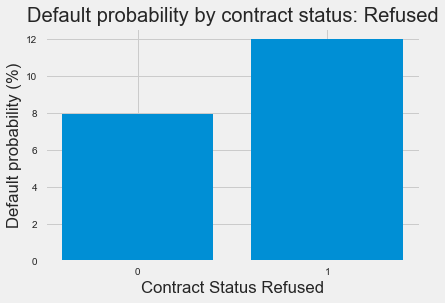

In [117]:
# Contract Status Refused is not a continuous variable, so we cannot use a KDE plot. 
# Instead, compare the default probability of clients who have contract status refused
# and those who do not.

contr_status = prev_app_tgt[['NAME_CONTRACT_STATUS_Refused','TARGET']].groupby('NAME_CONTRACT_STATUS_Refused').mean()

plt.bar(range(0,2),100*contr_status['TARGET'])
plt.xticks(range(0,2), range(0,2));
plt.xlabel('Contract Status Refused'); plt.ylabel('Default probability (%)'); plt.title('Default probability by contract status: Refused');

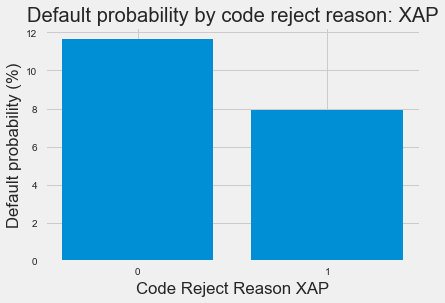

In [118]:
# Produce a histogram of default probability for CODE_REJECT_REASON_XAP.

code_reject = prev_app_tgt[['CODE_REJECT_REASON_XAP','TARGET']].groupby('CODE_REJECT_REASON_XAP').mean()

plt.bar(range(0,2),100*code_reject['TARGET'])
plt.xticks(range(0,2), range(0,2));
plt.xlabel('Code Reject Reason XAP'); plt.ylabel('Default probability (%)'); plt.title('Default probability by code reject reason: XAP');